In [17]:
# Import experimental feature first
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from mrmr import mrmr_classif

# Re-run the rest of the code now that IterativeImputer is properly enabled
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, GenericUnivariateSelect, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay,
    average_precision_score
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import optuna
from scipy.stats import gaussian_kde

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from tqdm import tqdm

import pymysql.cursors
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import clear_output
from sklearn.utils import resample

from connections import *
import pickle
import joblib

In [2]:
import pandas as pd
import plotly.graph_objects as go

def assign_color(prob):
    """
    Asigna un color pastel en base a la probabilidad.
    """
    if 0 <= prob < 0.25:
        return "#97ed95"  # Verde clarito pastel
    elif 0.25 <= prob < 0.4:
        return "#fff4c3"  # Amarillo pastel
    elif 0.4 <= prob < 0.5:
        return "#ffd1a1"  # Naranja pastel
    elif prob >= 0.5:
        return "#f6b2b0"  # Rojo pastel
    else:
        return "#d9d9d9"  # Neutro por defecto

def plot_patient_probability(df, patient_id, NAV, ultima_VMI):
    """
    Grafica las probabilidades de un paciente con colores según rangos de probabilidad
    y añade puntos rojos y verdes en las fechas de NAV (y 24h antes).

    Args:
    - df (pd.DataFrame): DataFrame con columnas ['PatientID', 'prob', 'AdmTimeHourlyFinal'].
    - patient_id (int): ID del paciente a graficar.
    - NAV (pd.DataFrame): DataFrame con columnas ['PatientID', 'fecha_NAV'].
    """
    # Filtrar el dataframe de probabilidades por el PatientID especificado
    patient_df = df[df['PatientID'] == patient_id].copy()

    # Asignar colores basados en la probabilidad
    patient_df['color'] = patient_df['prob'].apply(assign_color)

    # Filtrar el dataframe de NAV por el PatientID
    nav_df = NAV[NAV['PatientID'] == patient_id]

    ultima_VMI = ultima_VMI[ultima_VMI['PatientID'] == patient_id]

    # Crear la gráfica de Plotly
    fig = go.Figure()

    x_vals = patient_df['AdmTimeHourlyFinal'].values
    y_vals = patient_df['prob'].values
    color = patient_df['color'].values

    # Recorrer los valores y agregar cada segmento como una traza
    for i in range(1, len(x_vals)):
        fig.add_trace(go.Scatter(
            x=x_vals[i-1:i+1],  # Segmento de dos puntos
            y=y_vals[i-1:i+1],  # Segmento de dos puntos
            mode='lines',  # Solo líneas, sin puntos
            line=dict(color=color[i], width=3),  # Colorear cada segmento
            showlegend=False  # No mostrar cada segmento en la leyenda
        ))

    # Variables para controlar la leyenda
    first_nav = True
    first_24h = True

    # Si hay alguna fecha de NAV, agregar puntos rojos y verdes
    if not nav_df.empty:
        for _, row in nav_df.iterrows():
            fecha_nav = row['fecha_NAV']  # Obtener la fecha de NAV
            fecha_nav = pd.to_datetime(patient_df.loc[patient_df['AdmTimeHourlyFinal'] <= fecha_nav, 'AdmTimeHourlyFinal'].values[-1])
            fecha_24h = fecha_nav - pd.Timedelta(days=1)  # Calcular 24h antes de NAV
            
            # Obtener la probabilidad en las fechas específicas
            prob_nav = patient_df.loc[patient_df['AdmTimeHourlyFinal'] <= fecha_nav, 'prob'].values
            prob_24h = patient_df.loc[patient_df['AdmTimeHourlyFinal'] <= fecha_24h, 'prob'].values


            # Agregar punto rojo en fecha_NAV si existe probabilidad
            if prob_nav.size > 0:
                fig.add_trace(go.Scatter(
                    x=[fecha_nav],
                    y=[prob_nav[-1]],
                    mode='markers',
                    marker=dict(color='#fa8373', size=10),
                    name="NAV" if first_nav else None,
                    showlegend=first_nav
                ))
                first_nav = False

            # Agregar punto verde en fecha_24h si existe probabilidad
            if prob_24h.size > 0:
                fig.add_trace(go.Scatter(
                    x=[fecha_24h],
                    y=[prob_24h[-1]],
                    mode='markers',
                    marker=dict(color='#79e067', size=10),
                    name="24h Before NAV" if first_24h else None,
                    showlegend=first_24h
                ))
                first_24h = False
    else:
        fecha_ultima_VMI = ultima_VMI["ultima_VMI"].iloc[0]
        fecha_ultima_VMI = pd.to_datetime(patient_df.loc[patient_df['AdmTimeHourlyFinal'] <= fecha_ultima_VMI, 'AdmTimeHourlyFinal'].values[-1])
        fecha_24h = fecha_ultima_VMI - pd.Timedelta(days=1)  # Calcular 24h antes de NAV

        # Obtener la probabilidad en las fechas específicas
        prob_ultima_VMI = patient_df.loc[patient_df['AdmTimeHourlyFinal'] <= fecha_ultima_VMI, 'prob'].values
        prob_24h = patient_df.loc[patient_df['AdmTimeHourlyFinal'] <= fecha_24h, 'prob'].values
        
        # Agregar punto rojo en fecha ultima VMI si existe probabilidad
        if prob_ultima_VMI.size > 0:
            fig.add_trace(go.Scatter(
                x=[fecha_ultima_VMI],
                y=[prob_ultima_VMI[-1]],
                mode='markers',
                marker=dict(color='#7ec6f2', size=10),
                name="Last VMI" if first_nav else None,
                showlegend=True
            ))

        # Agregar punto verde en fecha_24h si existe probabilidad
        if prob_24h.size > 0:
            fig.add_trace(go.Scatter(
                x=[fecha_24h],
                y=[prob_24h[-1]],
                mode='markers',
                marker=dict(color='#79e067', size=10),
                name="24h Before Last VMI" if first_24h else None,
                showlegend=True
            ))

    # Agregar línea horizontal en y=0.5
    fig.add_hline(y=0.5, line_width=1, line_dash="solid", line_color="gray", name="Threshold 0.5")

    # Actualizar los detalles del gráfico
    fig.update_layout(
        title=f'Probabilidades para el PatientID {patient_id} con colores',
        xaxis_title='Tiempo (AdmTimeHourlyFinal)',
        yaxis_title='Probabilidad (prob)',
        showlegend=True,
        legend=dict(
            x=0.85,  # Posición horizontal (0: izquierda, 1: derecha)
            y=0.99,  # Posición vertical (0: abajo, 1: arriba)
            bgcolor='rgba(255, 255, 255, 0.5)',  # Fondo semitransparente
        ),
        yaxis=dict(
            range=[-0.05, 1.05],  # Rango del eje y
            tick0=0,       # Punto inicial de los ticks
            dtick=0.2      # Incremento entre los ticks
        ),
        height=400  # Alto de la gráfica
    )

    fig.update_layout(
    
)

    # Mostrar la gráfica
    fig.show()

# SHAP

In [3]:
import shap

In [4]:
final_model = CatBoostClassifier()
final_model.load_model("models/best_model_24h.cbm")

In [5]:
features_finales_24h_nav = ['peep_max', 'Age', 'pcr_median', 'antibioticos', 'temperatura_max', 'fio2_max', 'fr_min', 'fio2_median', 'pcr_min', 
                            'peep_median', 'aspecto_secreciones_purulentas', 'spo2_median', 'pr_plateau_min', 'pcr_max', 'temperatura_median', 
                            'fio2_min', 'pafi_min', 'linfocitos_min', 'pr_plateau_median', 'pr_peak_median', 'fr_median', 'pam_min', 
                            'noradrenalina_sum', 'linfocitos_median', 'pafi_median', 'linfocitos_max', 'pr_peak_max', 'peep_min', 'pam_median', 
                            'pr_peak_min', 'pafi_max', 'leucocitos_min', 'PatType_surgical', 'leucocitos_max', 'leucocitos_median', 'traqueo']
features_finales_24h_nav.extend(['NAV'])

df_test = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df_test_total = df_test.copy()
df_test = df_test[df_test.hr==-24].reset_index(drop=True)
df_test = df_test[features_finales_24h_nav]

X = df_test.drop("NAV", axis=1).copy()
y = df_test["NAV"].copy()
X_total = df_test_total["PatientID"].copy()
y_total = df_test_total["NAV"].copy()
columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
_, X_test_patients, _, _ = train_test_split(X_total, y_total, test_size=0.2, random_state=42, stratify=y_total)
X_test_patients = X_test_patients.values

# Imputación y downsampling final
imputer = IterativeImputer(max_iter=1000, random_state=42)
X_train_imp = imputer.fit_transform(X_train)

# Guardar el imputer entrenado
joblib.dump(imputer, "models/imputer_24.pkl")

# Recuperar el imputer en otra sesión
imputer_loaded = joblib.load("models/imputer_24.pkl")
X_test_imp = imputer_loaded.transform(X_test)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=columns)

In [6]:
y_pred_prob = final_model.predict_proba(X_test_imp)[:, 1]
y_pred = (y_pred_prob > 0.5).astype('int')

In [7]:
# load JS visualization code to notebook
shap.initjs()

In [8]:
X_test_imp_df.columns = [
    'PEEP_max', 'Age', 'CRP_median', 'Antibiotics', 'Temperature_max',
    'FiO2_max', 'RespRate_min', 'FiO2_median', 'CRP_min', 'PEEP_median',
    'Purulent_secretions', 'SpO2_median', 'PlateauPressure_min',
    'CRP_max', 'Temperature_median', 'FiO2_min', 'PaO2_FiO2_min',
    'Lymphocytes_min', 'PlateauPressure_median', 'PeakPressure_median',
    'RespRate_median', 'MAP_min', 'Norepinephrine_total',
    'Lymphocytes_median', 'PaO2_FiO2_median', 'Lymphocytes_max',
    'PeakPressure_max', 'PEEP_min', 'MAP_median', 'PeakPressure_min',
    'PaO2_FiO2_max', 'WBC_min', 'PatientType_surgical', 'WBC_max',
    'WBC_median', 'Tracheostomy'
]

In [9]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_imp)

In [10]:
import matplotlib

# Custom colormap (blue → white → red)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "custom_cmap", ["#1f77b4", "#f7f7f7", "#ff7f0e"]
)

*Frondelius T, Atkova I, Miettunen J, Rello J, Jansson MM. Diagnostic and prognostic prediction models in ventilator-associated pneumonia: Systematic review and meta-analysis of prediction modelling studies. J Crit Care 2022;67.*
https://doi.org/10.1016/j.jcrc.2021.10.001.

In [11]:
nums = [24, 18, 10,22,42,42,24,13,10,52,19,38,44,13,11,11,11,39,11,11,13,16,13,13,12,23,16,12,20,10,16]

In [12]:
np.round(np.mean(nums), 2)

20.29

In [13]:
np.round(np.std(nums), 2)

11.95

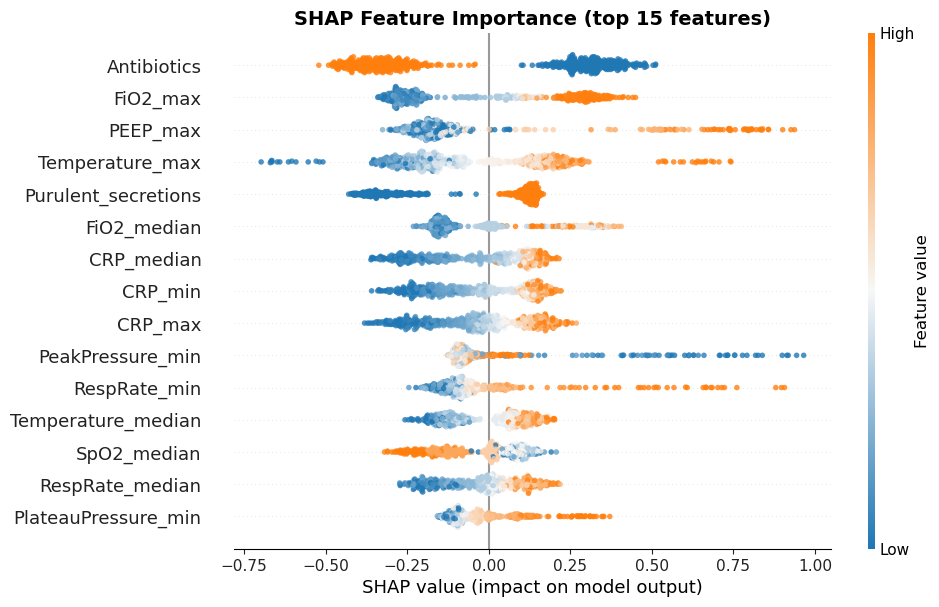

In [14]:
# Create the SHAP summary plot
shap.summary_plot(
    shap_values,
    features=X_test_imp_df,
    feature_names=X_test_imp_df.columns,
    max_display=15,                # top 15 features
    plot_type="dot",               # beeswarm style
    color=None,                    # let SHAP handle color
    cmap=custom_cmap,              # custom color scheme
    axis_color="#222222",          # darker axis color
    alpha=0.8,                     # softer transparency
    show=False,                    # don’t show, just build
    color_bar=True,
    color_bar_label="Feature value",
    plot_size=(10, 6),             # custom size (width, height)
    sort=True
)

# Add a unique title
plt.title("SHAP Feature Importance (top 15 features)", fontsize=14, fontweight="bold")
plt.show()

# Save the figure
plt.savefig("img/shap_15_features.png", format="png", dpi=600, bbox_inches="tight")


plt.close()

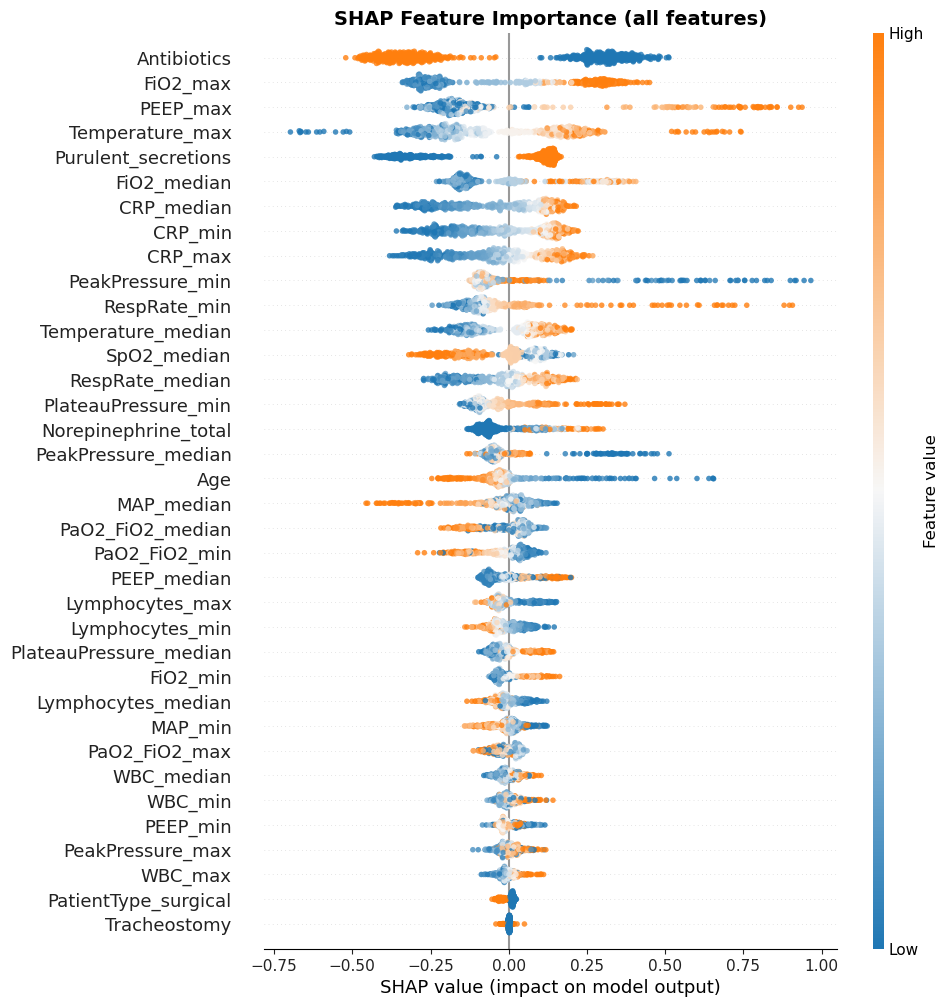

In [15]:
# Create the SHAP summary plot
shap.summary_plot(
    shap_values,
    features=X_test_imp_df,
    feature_names=X_test_imp_df.columns,
    max_display=36,                # top 15 features
    plot_type="dot",               # beeswarm style
    color=None,                    # let SHAP handle color
    cmap=custom_cmap,              # custom color scheme
    axis_color="#222222",          # darker axis color
    alpha=0.8,                     # softer transparency
    show=False,                    # don’t show, just build
    color_bar=True,
    color_bar_label="Feature value",
    plot_size=(10, 10),             # custom size (width, height)
    sort=True
)

# Add a unique title
plt.title("SHAP Feature Importance (all features)", fontsize=14, fontweight="bold")
plt.show()

# Save the figure
plt.savefig("img/shap_all_features.png", format="png", dpi=600, bbox_inches="tight")

plt.close()

# CALIBRATION PLOT

In [19]:
def calibrated_plot_compare(y_true_raw, y_proba_raw, y_true_cal, y_proba_cal, filename="calibration_compare.png"):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import statsmodels.api as sm
    import os

    blue="#1f77b4"
    orange="#ff7f0e"
    
    os.makedirs("img", exist_ok=True)
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    x_pred = np.linspace(0, 1, 200)
    X_pred = sm.add_constant(x_pred)

    # Línea de calibración perfecta
    ax.plot([0, 1], [0, 1], "--", lw=0.7, color="black", label="Perfect\ncalibration")

    # --- Modelo sin calibrar (azul) ---
    X_raw = sm.add_constant(y_proba_raw)
    logit_raw = sm.Logit(y_true_raw, X_raw).fit(disp=0)
    y_fit_raw = logit_raw.predict(X_pred)
    ci_raw = logit_raw.get_prediction(X_pred).conf_int()

    offset_raw = np.where(y_true_raw == 1, 0.05, -0.02)
    ax.scatter(y_proba_raw, y_true_raw + offset_raw,
               alpha=0.3, color=blue, label="Samples", s=12)

    ax.plot(x_pred, y_fit_raw, color=blue, lw=1.2, label="Curve")
    ax.fill_between(x_pred, ci_raw[:, 0], ci_raw[:, 1], color=blue, alpha=0.2, label="95% CI")

    # --- Modelo calibrado (naranja) ---
    X_cal = sm.add_constant(y_proba_cal)
    logit_cal = sm.Logit(y_true_cal, X_cal).fit(disp=0)
    y_fit_cal = logit_cal.predict(X_pred)
    ci_cal = logit_cal.get_prediction(X_pred).conf_int()

    offset_cal = np.where(y_true_cal == 1, 0.02, -0.05)
    ax.scatter(y_proba_cal, y_true_cal + offset_cal,
               alpha=0.3, color=orange, label="Samples", s=12)

    ax.plot(x_pred, y_fit_cal, color=orange, lw=1.5, label="Curve")
    ax.fill_between(x_pred, ci_cal[:, 0], ci_cal[:, 1], color=orange, alpha=0.2, label="95% CI")

    # Estética
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel("Predicted probability", fontsize=14)
    ax.set_ylabel("Observed probability", fontsize=14)
    ax.set_title("Comparison of Predicted vs. Observed Probabilities", fontsize=16, pad=15)

    # --- Leyendas separadas a la derecha ---
    handles, labels = ax.get_legend_handles_labels()

    # Perfect calibration (línea negra, primer handle)
    perfect = [handles[0]]
    perfect_labels = [labels[0]]

    # Uncalibrated = azul (siguientes tres)
    uncalibrated = handles[1:4]
    uncalibrated_labels = labels[1:4]

    # Calibrated = naranja (últimos tres)
    calibrated = handles[4:]
    calibrated_labels = labels[4:]

    # Leyenda "Perfect calibration" arriba
    leg0 = ax.legend(perfect, perfect_labels,
                     fontsize=11, loc="center left", bbox_to_anchor=(1.02, 0.85), frameon=False)
    ax.add_artist(leg0)

    # Leyenda azul
    leg1 = ax.legend(uncalibrated, uncalibrated_labels, title="Uncalibrated",
                     fontsize=11, loc="center left", bbox_to_anchor=(1.02, 0.65), frameon=False)
    ax.add_artist(leg1)

    # Leyenda naranja
    leg2 = ax.legend(calibrated, calibrated_labels, title="Calibrated",
                     fontsize=11, loc="center left", bbox_to_anchor=(1.02, 0.35), frameon=False)

    plt.tight_layout()
    save_path = os.path.join("img", filename)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

In [20]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=20, strategy='uniform')

In [21]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(final_model, method='isotonic', cv=5)
calibrated_model.fit(X_train_imp, y_train)

y_proba_cal = calibrated_model.predict_proba(X_test_imp)[:, 1]
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_cal, n_bins=20, strategy='uniform')

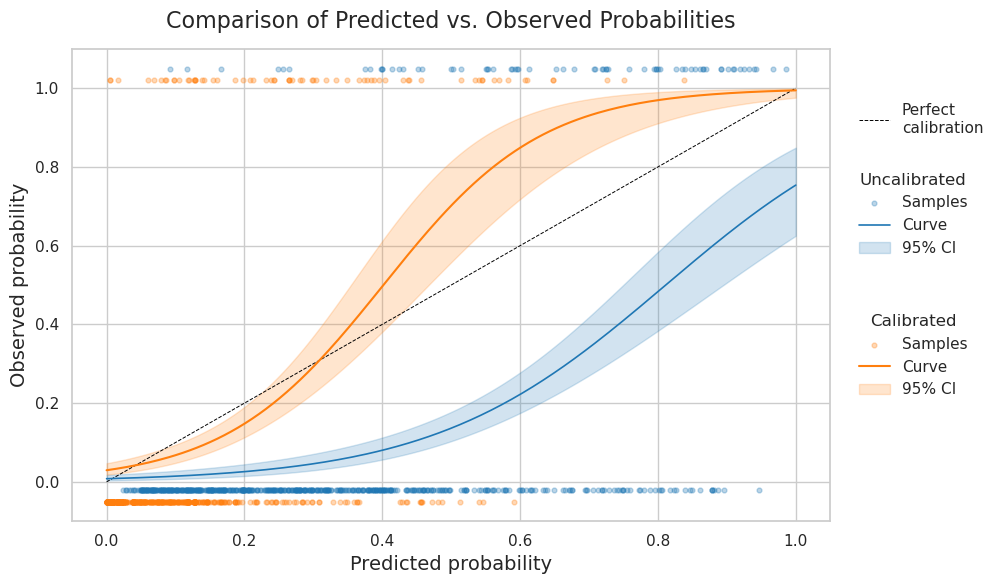

In [22]:
calibrated_plot_compare(
    y_true_raw=y_test, 
    y_proba_raw=y_pred_prob, 
    y_true_cal=y_test, 
    y_proba_cal=y_proba_cal, 
    filename="calibration_plot.png"
)